In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/porto-seguro-safe-driver-prediction/sample_submission.csv
/kaggle/input/porto-seguro-safe-driver-prediction/train.csv
/kaggle/input/porto-seguro-safe-driver-prediction/test.csv


In [2]:
train = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/test.csv', index_col='id')
submission = pd.read_csv('/kaggle/input/porto-seguro-safe-driver-prediction/sample_submission.csv', index_col='id')

In [3]:
train.shape, test.shape

((595212, 58), (892816, 57))

In [4]:
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
id,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,...,9,1,5,8,0,1,1,0,0,1
9,0,1,1,7,0,0,0,0,1,0,...,3,1,1,9,0,1,1,0,1,0
13,0,5,4,9,1,0,0,0,1,0,...,4,2,7,7,0,1,1,0,1,0
16,0,0,1,2,0,0,1,0,0,0,...,2,2,4,9,0,0,0,0,0,0
17,0,0,2,0,1,0,1,0,0,0,...,3,1,1,3,0,0,0,1,1,0


In [5]:
submission.head()

,target
id,
0,0.0364
1,0.0364
2,0.0364
3,0.0364
4,0.0364


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595212 entries, 7 to 1488027
Data columns (total 58 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   target          595212 non-null  int64  
 1   ps_ind_01       595212 non-null  int64  
 2   ps_ind_02_cat   595212 non-null  int64  
 3   ps_ind_03       595212 non-null  int64  
 4   ps_ind_04_cat   595212 non-null  int64  
 5   ps_ind_05_cat   595212 non-null  int64  
 6   ps_ind_06_bin   595212 non-null  int64  
 7   ps_ind_07_bin   595212 non-null  int64  
 8   ps_ind_08_bin   595212 non-null  int64  
 9   ps_ind_09_bin   595212 non-null  int64  
 10  ps_ind_10_bin   595212 non-null  int64  
 11  ps_ind_11_bin   595212 non-null  int64  
 12  ps_ind_12_bin   595212 non-null  int64  
 13  ps_ind_13_bin   595212 non-null  int64  
 14  ps_ind_14       595212 non-null  int64  
 15  ps_ind_15       595212 non-null  int64  
 16  ps_ind_16_bin   595212 non-null  int64  
 17  ps_ind_17

### 결측값 시각화

<AxesSubplot:>

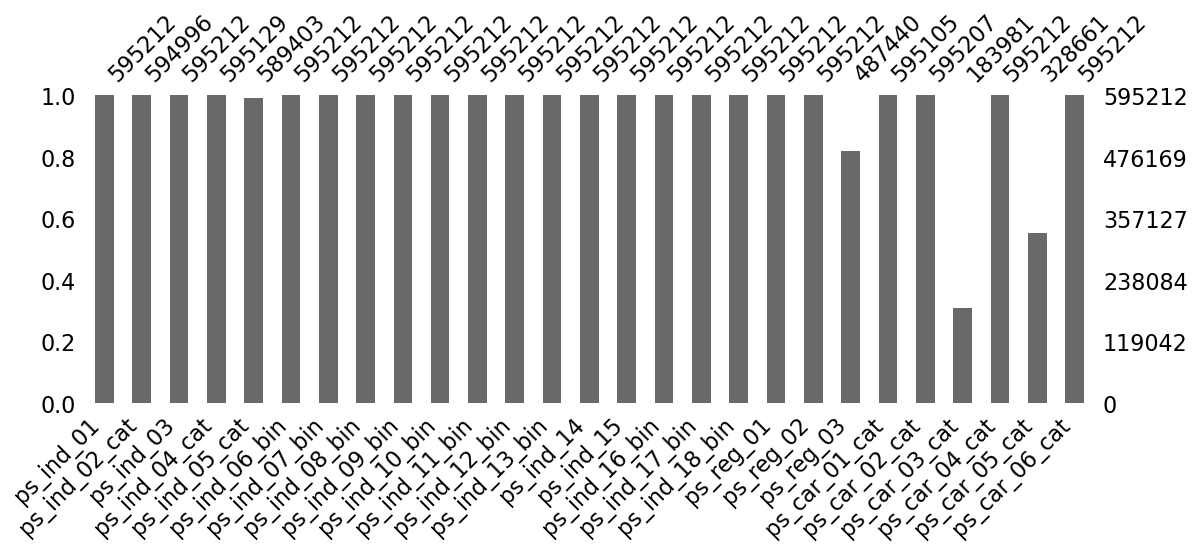

In [7]:
import missingno as msno

train_copy = train.copy().replace(-1, np.NaN)
msno.bar(df=train_copy.iloc[:,1:28], figsize=(13,4)) # 처음 28개만

<AxesSubplot:>

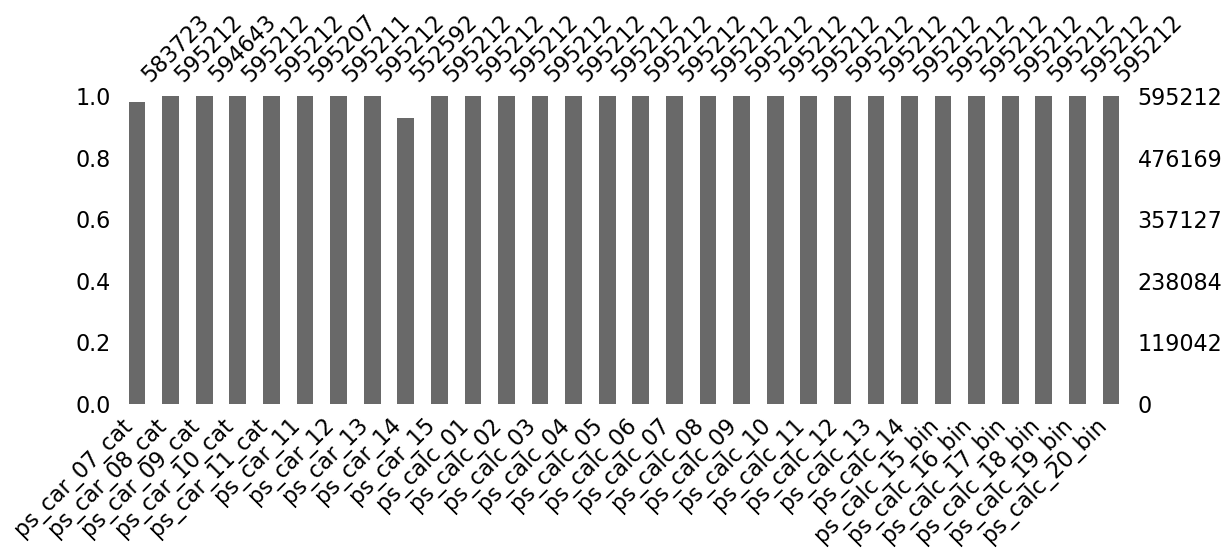

In [8]:
msno.bar(df=train_copy.iloc[:,28:], figsize=(13,4))

<AxesSubplot:>

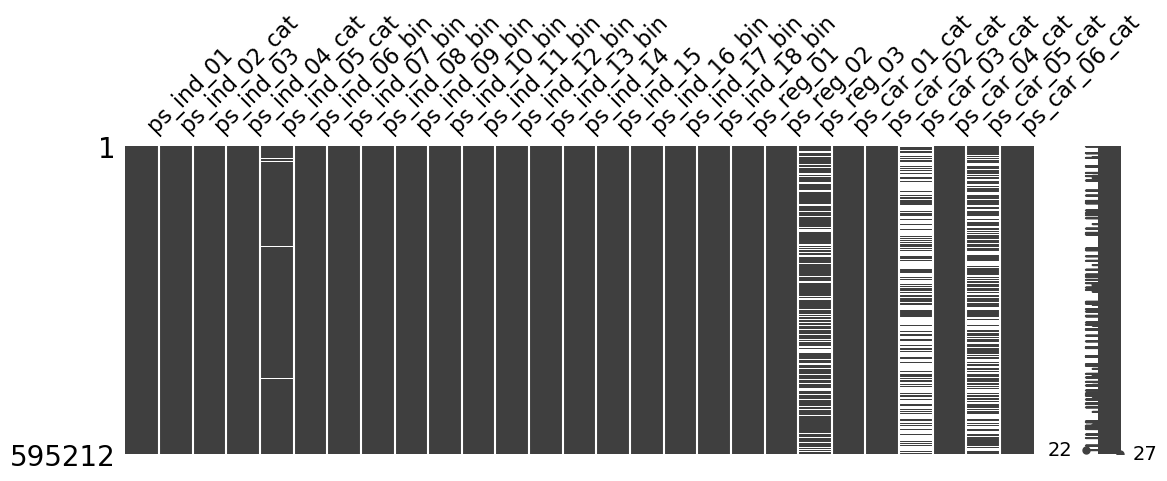

In [9]:
msno.matrix(df=train_copy.iloc[:,1:28], figsize=(13,4)) #22는 결측값이 없는 열 개수

In [10]:
# 피처 요약표

def resumetable(df):
    print(f'데이터셋 형상: {df.shape}')
    summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
    summary['결측값 개수'] = (df==-1).sum().values
    summary['고윳값 개수'] = df.nunique().values
    summary['데이터 종류'] = None
    
    for col in df.columns:
        if 'bin' in col or col == 'target':
            summary.loc[col, '데이터 종류'] = '이진형'
        elif 'cat' in col:
            summary.loc[col, '데이터 종류'] = '명목형'
        elif df[col].dtype == float:
            summary.loc[col, '데이터 종류'] = '연속형'
        elif df[col].dtype == int:
            summary.loc[col, '데이터 종류'] = '순서형'
    
    return summary

In [11]:
summary = resumetable(train)
summary

데이터셋 형상: (595212, 58)


,데이터 타입,결측값 개수,고윳값 개수,데이터 종류
target,int64,0,2,이진형
ps_ind_01,int64,0,8,순서형
ps_ind_02_cat,int64,216,5,명목형
ps_ind_03,int64,0,12,순서형
ps_ind_04_cat,int64,83,3,명목형
ps_ind_05_cat,int64,5809,8,명목형
ps_ind_06_bin,int64,0,2,이진형
ps_ind_07_bin,int64,0,2,이진형
ps_ind_08_bin,int64,0,2,이진형
ps_ind_09_bin,int64,0,2,이진형


In [12]:
summary[summary['데이터 종류'] == '명목형'].index

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat',
       'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat',
       'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object')

In [13]:
summary[summary['데이터 타입'] == 'float64'].index

Index(['ps_reg_01', 'ps_reg_02', 'ps_reg_03', 'ps_car_12', 'ps_car_13',
       'ps_car_14', 'ps_car_15', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03'],
      dtype='object')

# 타깃값 분포

In [14]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

Text(0.5, 1.0, 'Target Distribution')

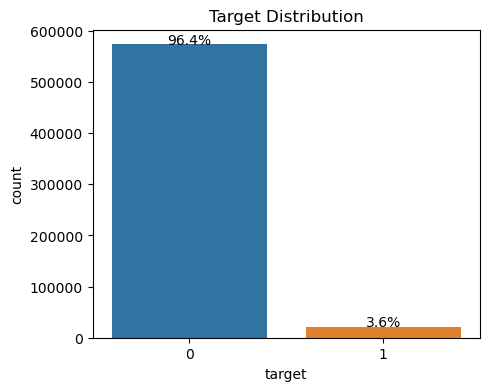

In [15]:
# 7장 타깃값 분포 코드 재활용

def write_percent(ax, total_size):
    for patch in ax.patches:
        height = patch.get_height()
        width = patch.get_width()
        left_coord = patch.get_x()
        percent = height/total_size * 100
        
        # (x, y) 좌표에 텍스트 입력
        ax.text(x=left_coord + width/2.0,
                y=height + total_size*0.001,
                s=f'{percent:1.1f}%', # 입력 텍스트
                ha='center') # 가운데 정렬

plt.figure(figsize=(5, 4))

ax = sns.countplot(x='target', data=train)
write_percent(ax, len(train))
ax.set_title("Target Distribution")

# 이진 피처

In [16]:
# 7장 코드 응용

import matplotlib.gridspec as gridspec

def plot_target_ratio_by_features(df, features, num_rows, num_cols, size=(12,18)):
    mpl.rc('font', size=9)
    plt.figure(figsize = size)
    grid = gridspec.GridSpec(num_rows, num_cols) #서브플롯 배치
    plt.subplots_adjust(wspace=0.3, hspace=0.3) #서브플롯 간격
    
    for idx, feature in enumerate(features):
        ax = plt.subplot(grid[idx])
        sns.barplot(x=feature, y='target', data=df, palette='Set2', ax=ax) # 고윳값별 타깃값 1 비율

In [17]:
bin_features = summary[summary['데이터 종류'] == '이진형'].index
len(bin_features)

18

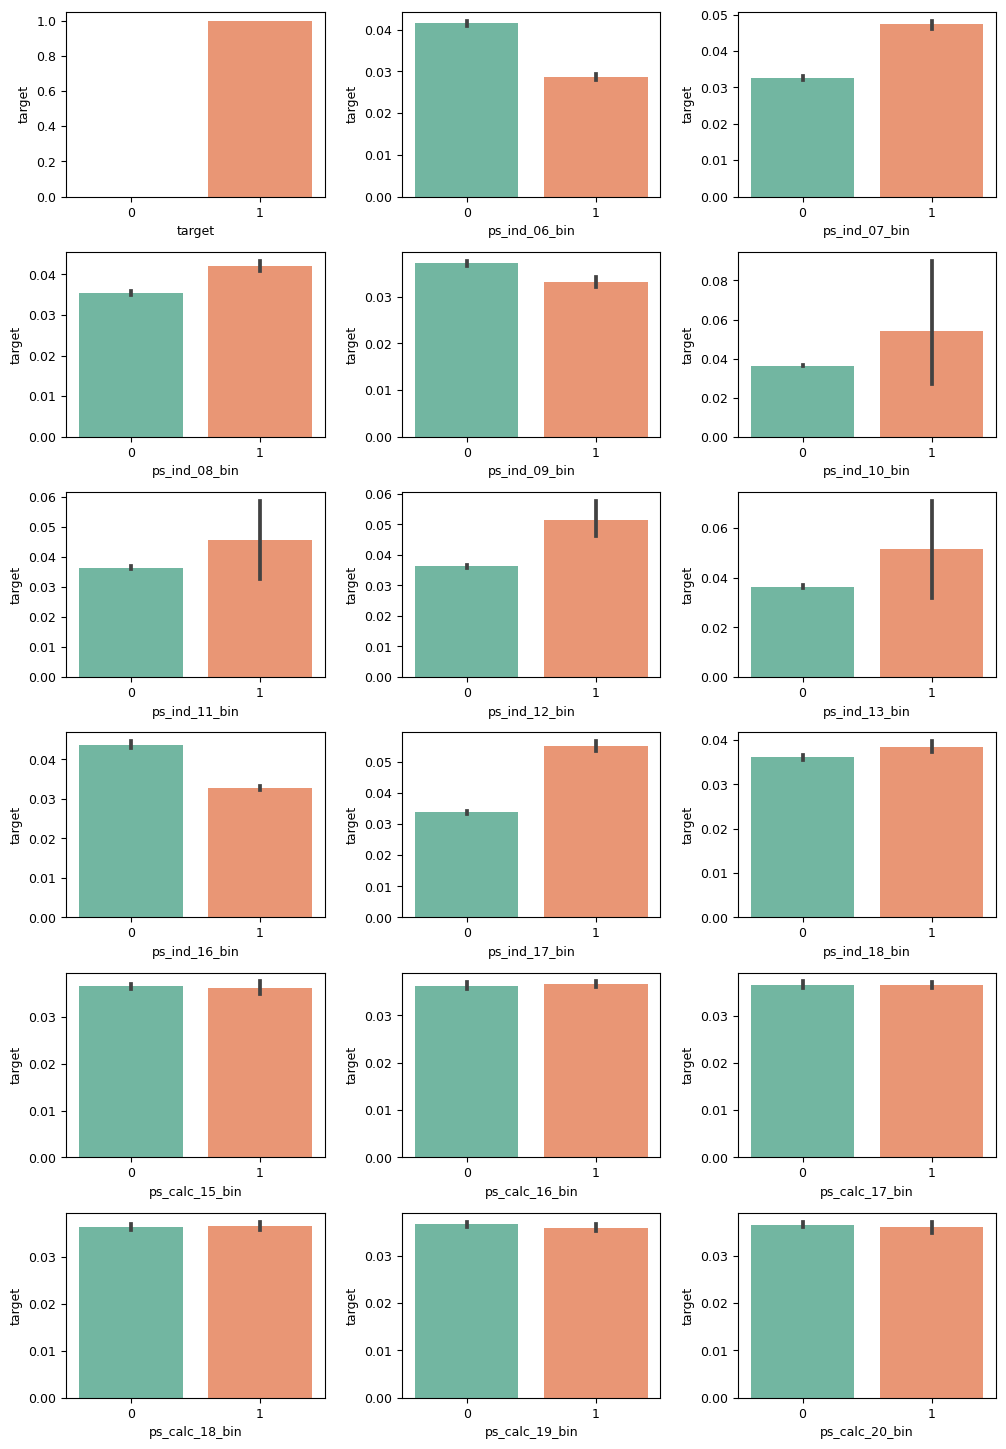

In [18]:
plot_target_ratio_by_features(train, bin_features, 6, 3)

#### 제거해야할 피처   
ind_0 ~ 13 : 신뢰구간이 너무 넓음   
calc_15 ~ 20 : 타깃값 비율 차이가 유의미하지 않음 (calc 피처들은 모두 별로란 말인데 나중에 확인필요)

# 명목형 피처

In [19]:
nom_features = summary[summary['데이터 종류'] == '명목형'].index
len(nom_features)

14

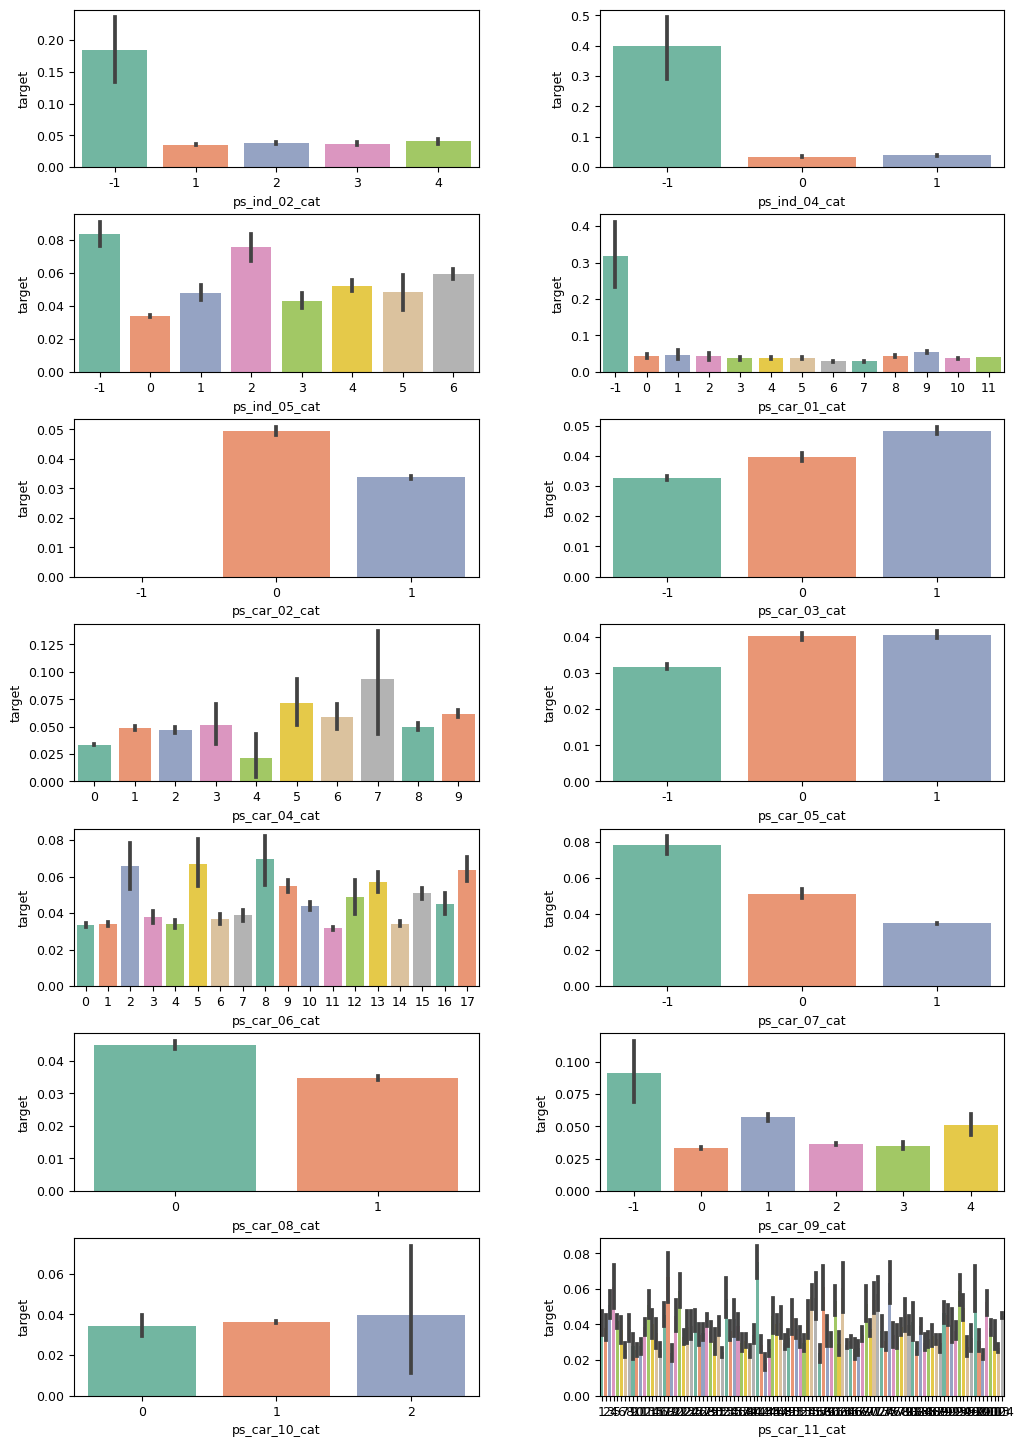

In [20]:
plot_target_ratio_by_features(train, nom_features, 7, 2)

#### 제거해야할 피처 없음   
결측값(-1) 자체가 예측에 도움이 되는 경우가 있다.   
ind_02_cat, car_02_cat 의 경우 처럼 결측값을 그대로 두고 하나의 고윳값으로 간주해도 무방하다.   
> 결측값 자체에 타깃값 예측력이 있다면 고윳값으로 간주(결측값 처리 필요없음)    

(1~3번) 신회구간이 넓더라도 신뢰하한과 다른 고윳값들의 신뢰상한 간의 차이가 크면 충분히 의미가 있을 수 있음  
car_10_cat : 고윳값 2의 신뢰구간이 유독 넓음. 이 피처를 제거한 경우와 제거하지 않은 경우를 비교해 보아야함

# 순서형 피처

In [21]:
ord_features = summary[summary['데이터 종류'] == '순서형'].index
len(ord_features)

16

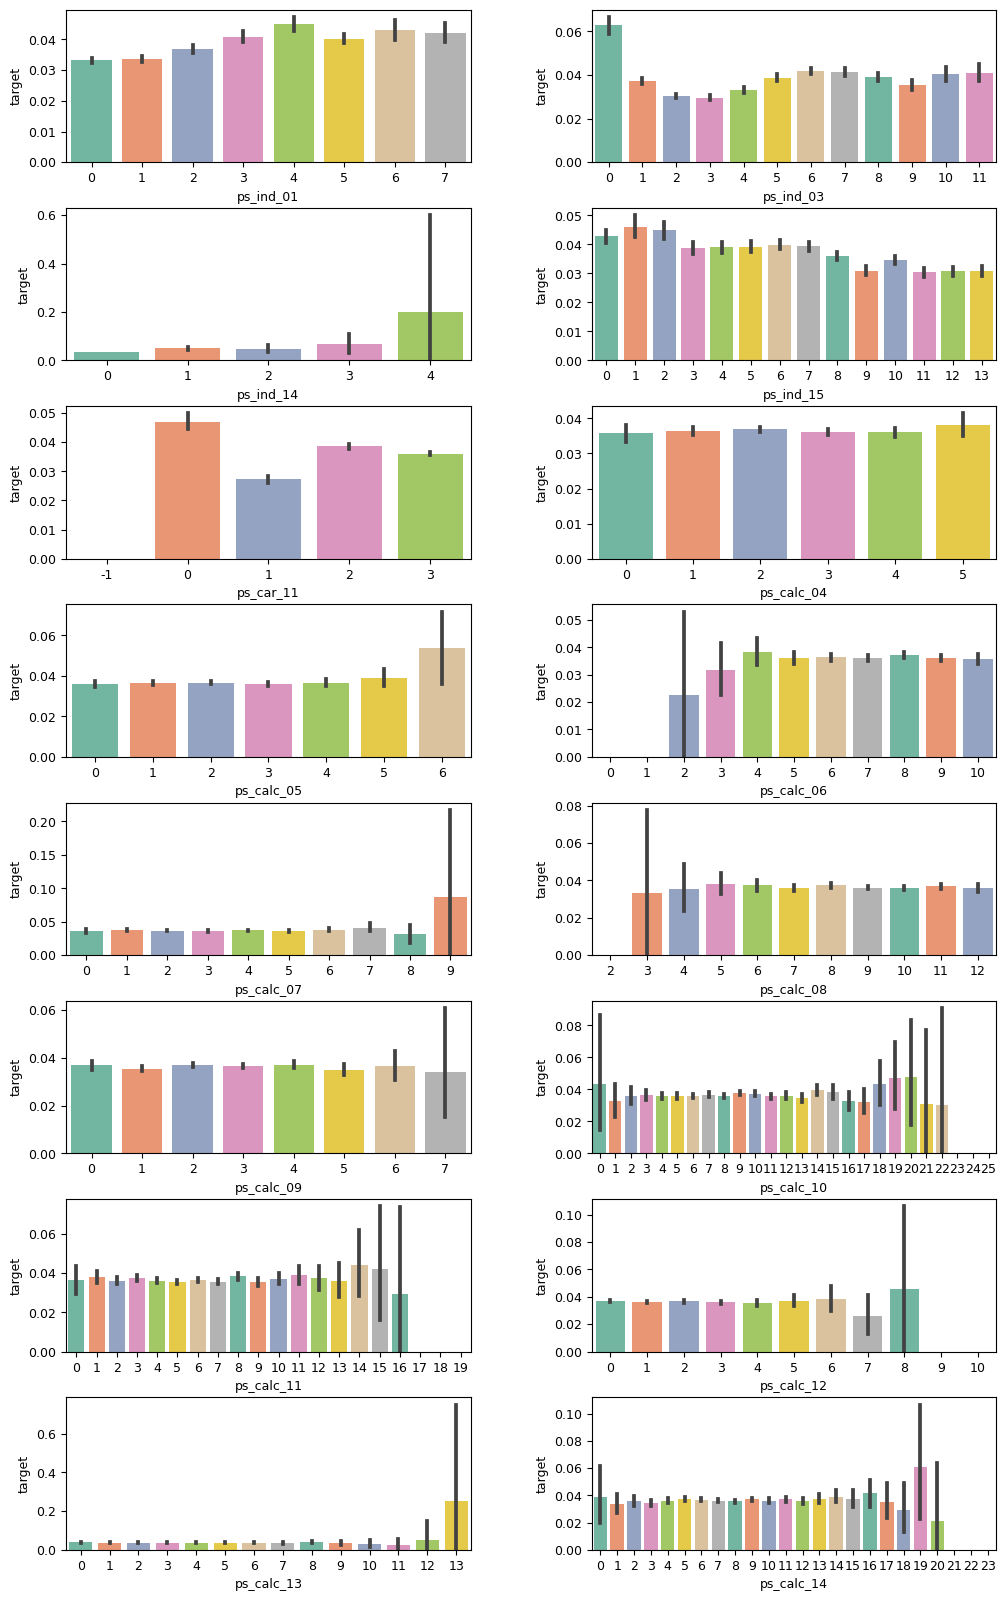

In [22]:
plot_target_ratio_by_features(train, ord_features, 8, 2, (12,20))

#### 제거해야할 피처   
ind_14 : 1,2,3은 비율이 비슷, 4는 신뢰구간이 너무 넓음   
calc_4 ~ 14 : 모두 통계적 유효성이 떨어짐 (이진 피처에서 처럼 calc 피처들은 모두 별로다.)

# 연속형 피처   
연속형 피처는 고윳값이 많으므로 값을 몇 개의 구간으로 나누어서 구간별 타깃값의 비율을 알아낸다.   
판다스의 cut() 사용, 연속형 데이터를 범주형 데이터로 바꾸는 효과가 있음
```python
pd.cut([1.0, 1.5, 2.1, 2.7, 3.5, 4.0], 3) # 두 번째 인수가 나눌 구간의 개수  
```


In [23]:
pd.cut([1.0, 1.5, 2.1, 2.7, 3.5, 4.0], 3)

[(0.997, 2.0], (0.997, 2.0], (2.0, 3.0], (2.0, 3.0], (3.0, 4.0], (3.0, 4.0]]
Categories (3, interval[float64, right]): [(0.997, 2.0] < (2.0, 3.0] < (3.0, 4.0]]

In [24]:
cont_features = summary[summary['데이터 종류'] == '연속형'].index
len(cont_features)

10

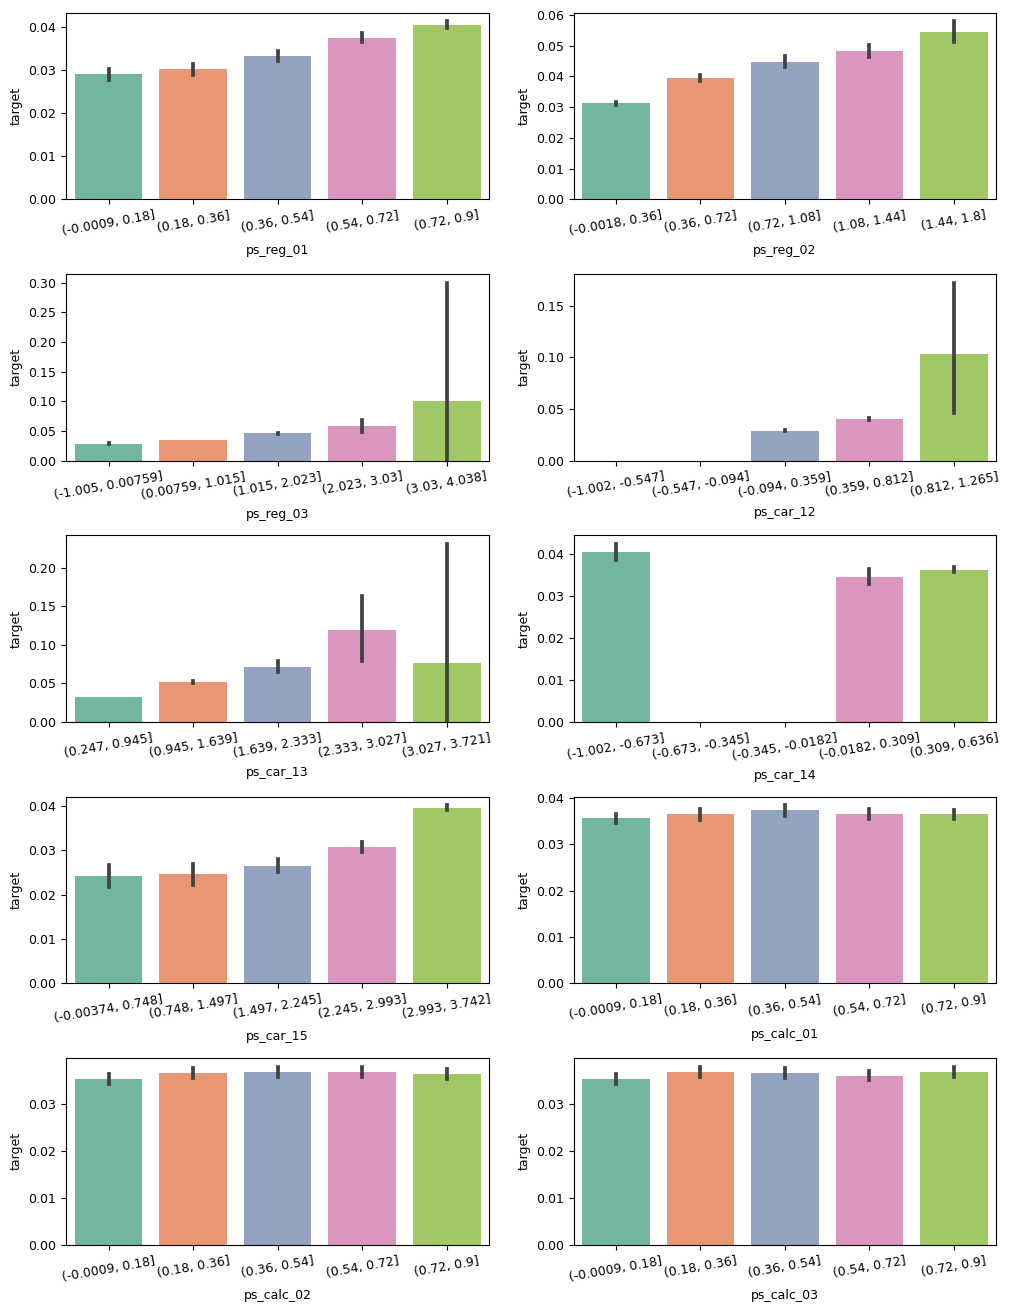

In [25]:
plt.figure(figsize=(12,16))
grid = gridspec.GridSpec(5, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for idx, feature in enumerate(cont_features):
    
    train[feature] = pd.cut(train[feature],5)
    
    ax = plt.subplot(grid[idx])
    sns.barplot(x=feature, y='target', data=train, palette='Set2', ax=ax)
    ax.tick_params(axis='x', labelrotation=10) #x축 라벨 회전

#### 제거해야 할 피처   
calc_1~3 : 구간별 비율 차이 없음 -> calc 피처들은 모두 삭제


## 연속형 피처 간 상관관계   
히트맵 :   
 일반적으로 강한 상관관계를 보이는 두 피처가 있으면 둘 중 하나는 제거하는 게 좋음 -> 상관관계가 강하다 = 타깃값 예측력이 비슷하다

<AxesSubplot:>

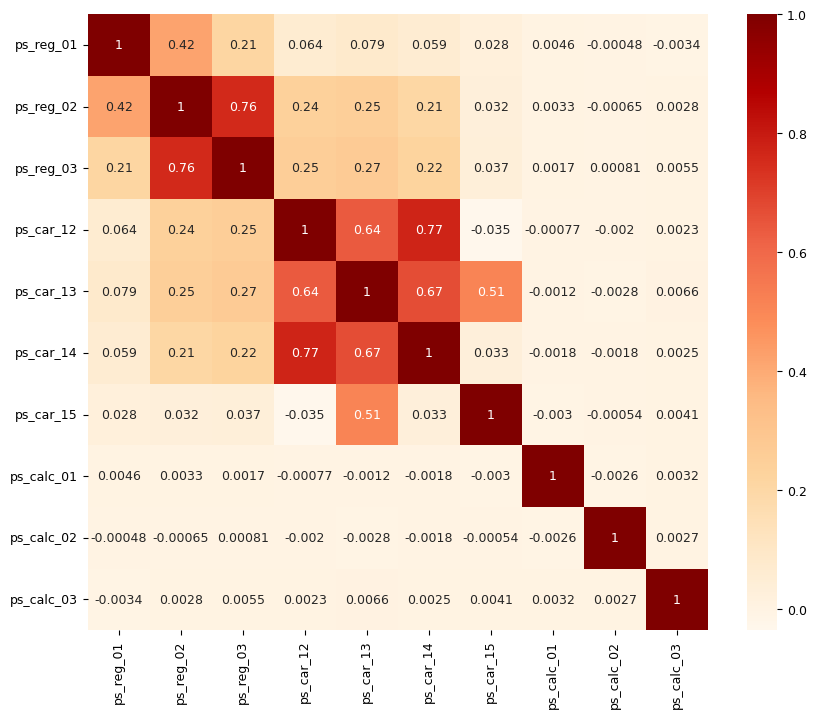

In [26]:
# 결측값 제거
train_copy = train_copy.dropna()

plt.figure(figsize = (10, 8))
cont_corr = train_copy[cont_features].corr()
sns.heatmap(cont_corr, annot=True, cmap='OrRd')

### 제거해야 할 피처   
car_12와 car_14의 상관관계가 0.77 -> car_14 제거